In [1]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.head(5)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [5]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

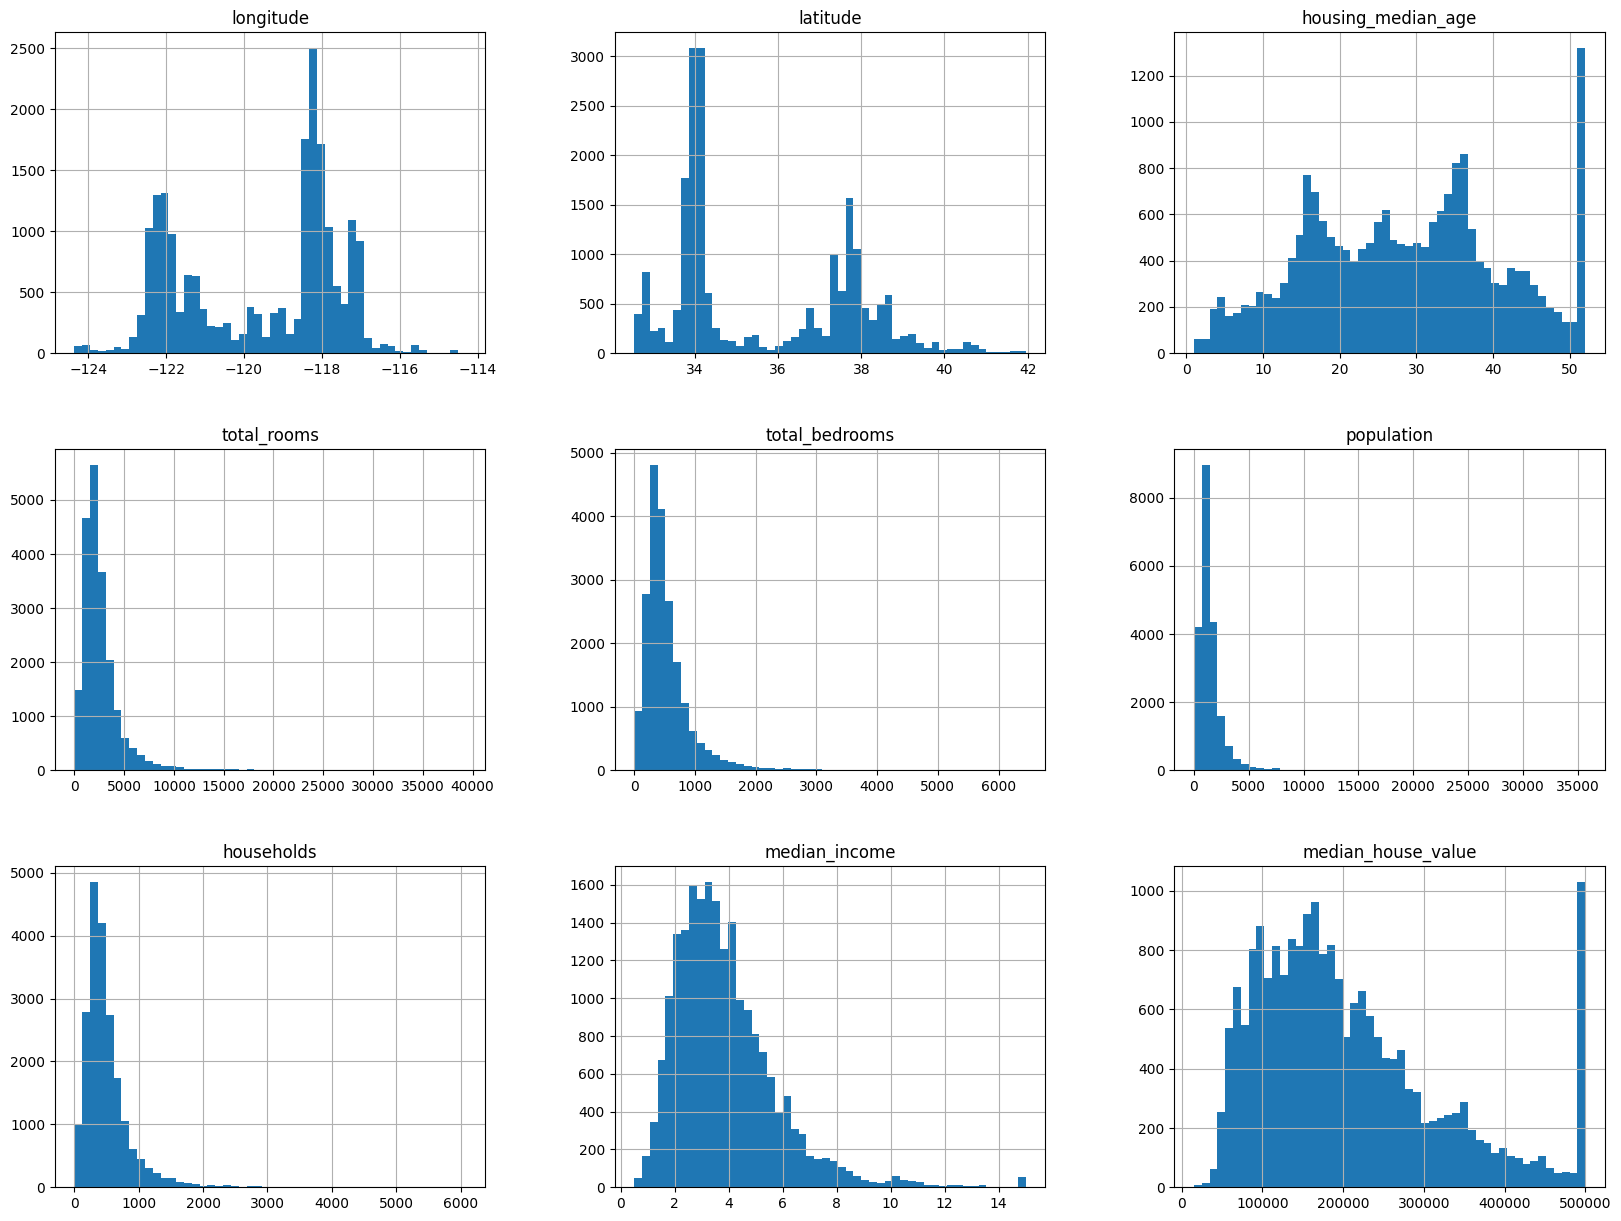

In [6]:
%matplotlib inline   
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [7]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [8]:
train_set, test_set = split_train_test(housing, 0.2)

In [9]:
len(train_set)

16512

In [10]:
len(test_set)

4128

In [11]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
housing_with_id = housing.reset_index()

In [13]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [14]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [16]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

<Axes: >

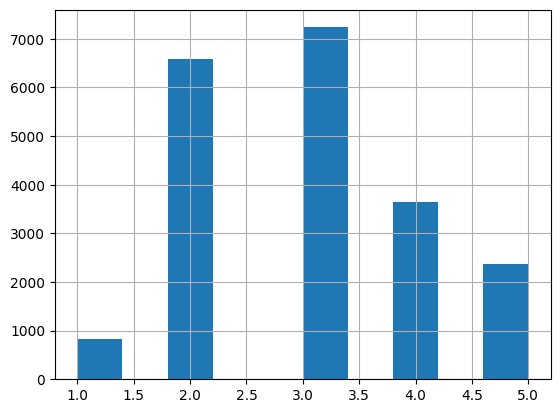

In [17]:
housing["income_cat"].hist()

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [19]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [20]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [21]:
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

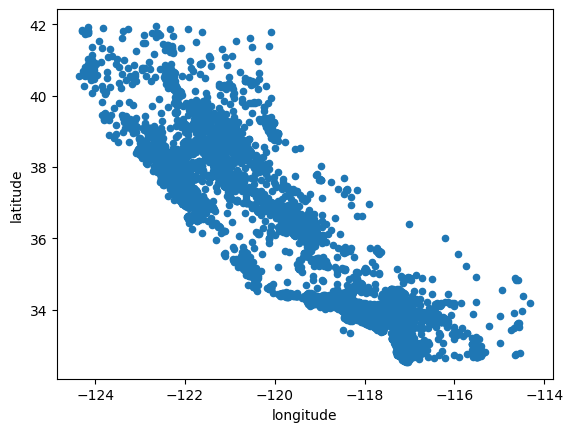

In [22]:
housing.plot(kind="scatter", x="longitude", y="latitude")

<Axes: xlabel='longitude', ylabel='latitude'>

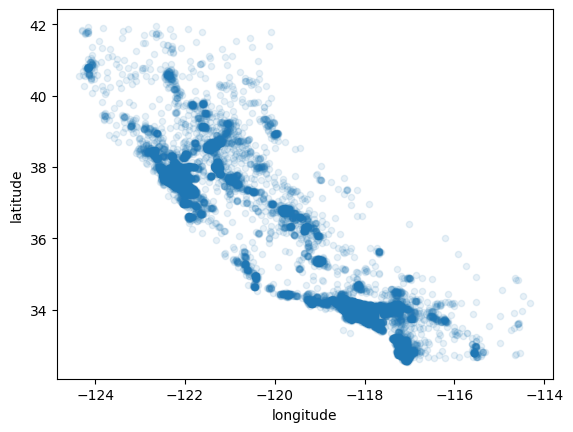

In [23]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

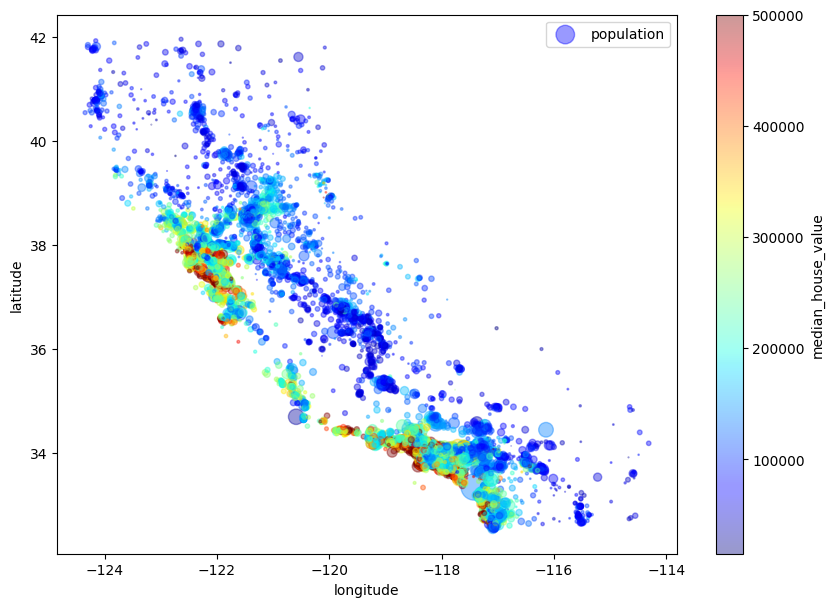

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()


In [25]:
#Looking for Correlations

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

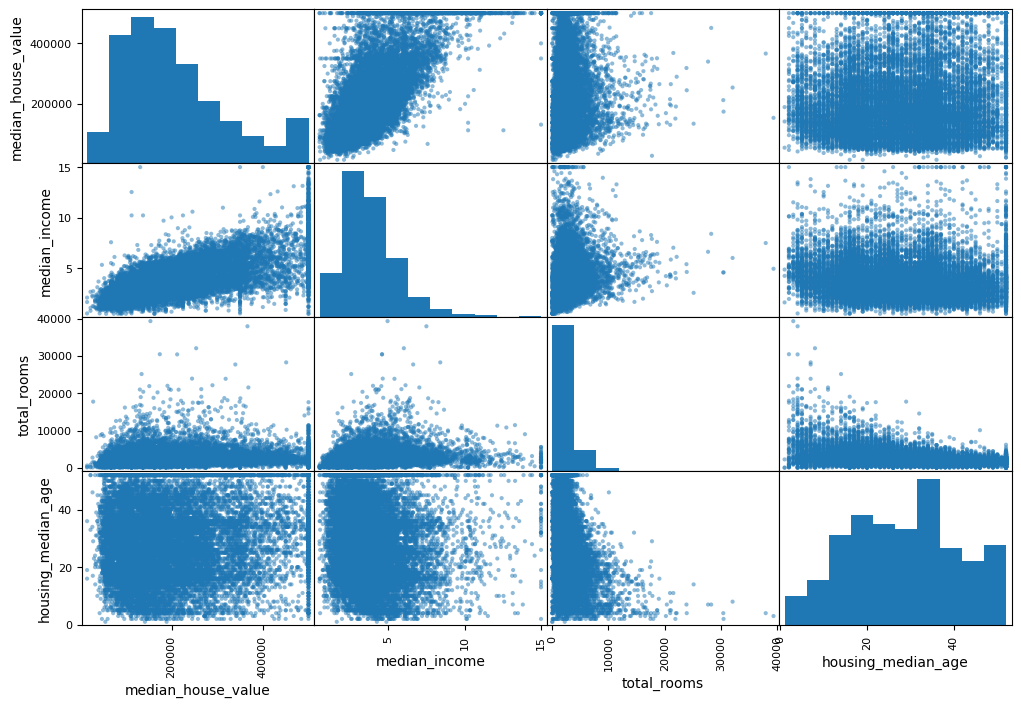

In [26]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

<Axes: xlabel='median_income', ylabel='median_house_value'>

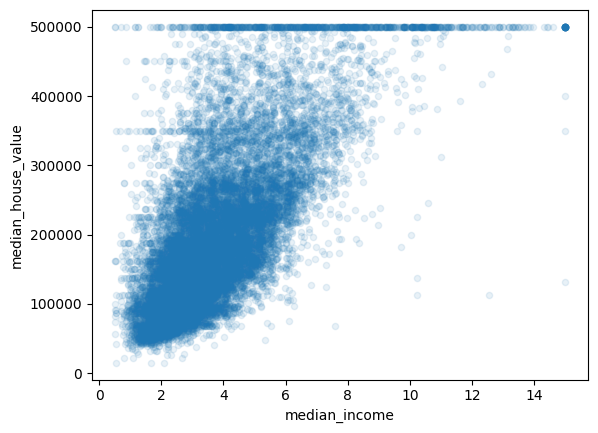

In [27]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)

In [28]:
#Experimenting with Attribute Combinations

In [29]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [30]:
#Prepare the Data for Machine Learning Algorithms

In [31]:
housing = strat_train_set.drop("median_house_value", axis=1)

In [32]:
housing_labels = strat_train_set["median_house_value"].copy()

In [33]:
housing.dropna(subset=["total_bedrooms"])    
housing.drop("total_bedrooms", axis=1)       
median = housing["total_bedrooms"].median()  
housing["total_bedrooms"].fillna(median, inplace=True)

In [34]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [35]:
housing_num = housing.drop("ocean_proximity", axis=1)

In [36]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [37]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [38]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [39]:
X = imputer.transform(housing_num)

In [40]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [41]:
#Handling Text and Categorical Attributes

In [42]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

ocean_proximity
12655          INLAND
15502      NEAR OCEAN
2908           INLAND
14053      NEAR OCEAN
20496       <1H OCEAN
1481         NEAR BAY
18125       <1H OCEAN
5830        <1H OCEAN
17989       <1H OCEAN
4861        <1H OCEAN

In [43]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [44]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [45]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [46]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [47]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [48]:
#Custom Transformers

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [50]:
#Transformation Pipelines

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [52]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [53]:
#Select and Train a Model

In [54]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [55]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [56]:
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [57]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

In [58]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [59]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [60]:
#Better Evaluation Using Cross-Validation

In [61]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)


In [62]:
def display_scores(scores):
...     print("Scores:", scores)
...     print("Mean:", scores.mean())
...     print("Standard deviation:", scores.std())

In [63]:
display_scores(tree_rmse_scores)

Scores: [71506.55986038 70837.65484191 68372.90793047 69540.8630673
 70366.15053019 77047.70464597 70881.68151051 73492.45041168
 68217.348073   70265.50595844]
Mean: 71052.8826829856
Standard deviation: 2465.180005392921


In [64]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
...                              scoring="neg_mean_squared_error", cv=10)

In [65]:
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.328209818062


In [66]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
[...]
#forest_rmse

[Ellipsis]

In [67]:
#Fine-Tune Your Model

In [68]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [69]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [70]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [71]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64396.55518581866 {'max_features': 2, 'n_estimators': 3}
55531.39651242342 {'max_features': 2, 'n_estimators': 10}
52488.843675767384 {'max_features': 2, 'n_estimators': 30}
60623.055135276416 {'max_features': 4, 'n_estimators': 3}
53306.37638061375 {'max_features': 4, 'n_estimators': 10}
50663.379060257634 {'max_features': 4, 'n_estimators': 30}
59191.759426672696 {'max_features': 6, 'n_estimators': 3}
52129.92433615953 {'max_features': 6, 'n_estimators': 10}
49780.0511731755 {'max_features': 6, 'n_estimators': 30}
59362.88840936576 {'max_features': 8, 'n_estimators': 3}
52361.30449760864 {'max_features': 8, 'n_estimators': 10}
50052.48446927483 {'max_features': 8, 'n_estimators': 30}
62202.40586524495 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54239.18778269112 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59335.98006191331 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52798.28782338801 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [72]:
#Analyze the Best Models and Their Errors

In [73]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.97365444e-02, 7.37021715e-02, 4.22063435e-02, 2.22192676e-02,
       1.65543656e-02, 1.82054948e-02, 1.63888150e-02, 2.83176556e-01,
       7.64374070e-02, 1.08496883e-01, 7.97560934e-02, 1.10959015e-02,
       1.65196884e-01, 1.00159956e-04, 3.07041501e-03, 3.65669873e-03])

In [74]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.28317655560111116, 'median_income'),
 (0.16519688375147945, 'INLAND'),
 (0.10849688265533029, 'pop_per_hhold'),
 (0.07975609342524978, 'bedrooms_per_room'),
 (0.0797365444481218, 'longitude'),
 (0.0764374069646827, 'rooms_per_hhold'),
 (0.07370217149267046, 'latitude'),
 (0.04220634348745426, 'housing_median_age'),
 (0.02221926756327654, 'total_rooms'),
 (0.018205494824142226, 'population'),
 (0.016554365575906452, 'total_bedrooms'),
 (0.016388814977038146, 'households'),
 (0.011095901540429602, '<1H OCEAN'),
 (0.0036566987285832383, 'NEAR OCEAN'),
 (0.003070415008296762, 'NEAR BAY'),
 (0.0001001599562271385, 'ISLAND')]

In [75]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)  

In [76]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45849.69826395, 49700.16459019])

In [77]:
#Exercises

In [78]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score



In [79]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ..............................C=10.0, kernel=linear; total time=   6.9s
[CV] END ..............................C=10.0, kernel=linear; total time=   7.0s
[CV] END ..............................C=10.0, kernel=linear; total time=   6.4s
[CV] END ..............................C=10.0, kernel=linear; total time=   6.4s
[CV] END ..............................C=10.0, kernel=linear; total time=   6.5s
[CV] END ..............................C=30.0, kernel=linear; total time=   6.6s
[CV] END ..............................C=30.0, kernel=linear; total time=   6.5s
[CV] END ..............................C=30.0, kernel=linear; total time=   6.5s
[CV] END ..............................C=30.0, kernel=linear; total time=   6.5s
[CV] END ..............................C=30.0, kernel=linear; total time=   6.5s
[CV] END .............................C=100.0, kernel=linear; total time=   6.6s
[CV] END .............................C=100.0, 

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

In [80]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70286.61836196149

In [81]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

In [82]:
#2

In [83]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
random_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
random_search.fit(housing_prepared, housing_labels)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   4.2s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   4.0s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   4.2s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   4.0s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   4.2s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   7.5s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   7.5s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   7.7s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   7.8s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=   7.7s
[CV] END C=84.1410790057587, gamma=0.059838768608680676, kernel

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f561d5780d0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f55fe57a980>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [84]:
negative_mse = random_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54751.69009256622

In [85]:
random_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

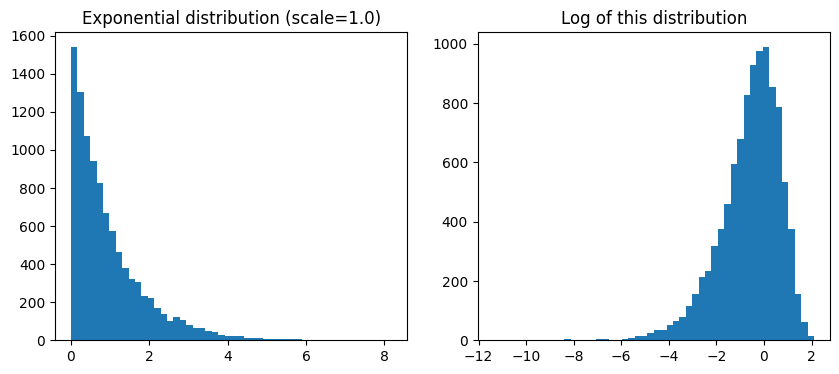

In [86]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

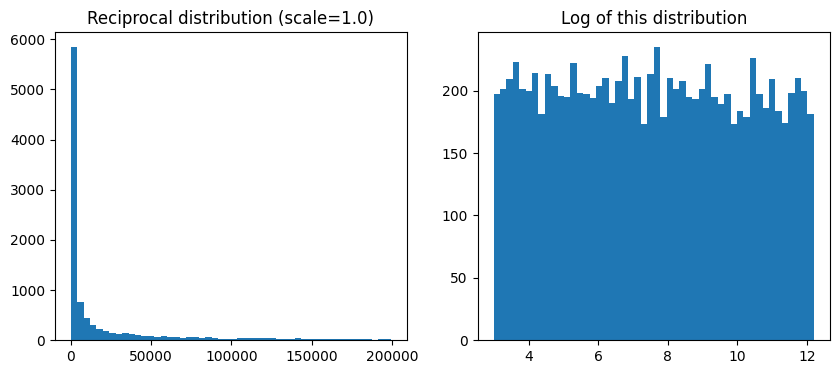

In [87]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

In [88]:
#3

In [89]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [90]:
k = 5

In [91]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  7,  9, 10, 12])

In [92]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'median_income', 'pop_per_hhold', 'bedrooms_per_room',
       'INLAND'], dtype='<U18')

In [93]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.28317655560111116, 'median_income'),
 (0.16519688375147945, 'INLAND'),
 (0.10849688265533029, 'pop_per_hhold'),
 (0.07975609342524978, 'bedrooms_per_room'),
 (0.0797365444481218, 'longitude')]

In [94]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [99]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [100]:
housing_prepared_top_k_features[0:3]

array([[-0.94135046, -0.8936472 ,  0.00622264, -0.12112176,  1.        ],
       [ 1.17178212,  1.292168  , -0.04081077, -0.81086696,  0.        ],
       [ 0.26758118, -0.52543365, -0.07537122, -0.33827252,  1.        ]])

In [101]:
housing_prepared[0:3, top_k_feature_indices]

array([[-0.94135046, -0.8936472 ,  0.00622264, -0.12112176,  1.        ],
       [ 1.17178212,  1.292168  , -0.04081077, -0.81086696,  0.        ],
       [ 0.26758118, -0.52543365, -0.07537122, -0.33827252,  1.        ]])

In [ ]:
#4

In [105]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**random_search.best_params_))
])

In [106]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat', OneHotEncoder(...
                 TopFeatureSelector(feature_importances=array([7.97365444e-02, 7.37021715e-02, 4.22063435e-02, 2.22192676e-02,
       1.65543656e-02, 1.82054948e-02, 1.63888150e-02, 2.83176556e-01,
       7.64374070e-02, 1.08496883e-01, 7.97560934e-02, 1.10959015e-02,
       1.65196884e-01, 1.00159956e-04, 3.07041501e-03, 3.65669873e-03]),
                                    k=5)),
                ('svm_reg',
                 SVR(C=157055.10989448498, gamma=0.26497040005002437))])

In [107]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 82915.77062052 288057.72329295  95680.82648363 149790.34263837]
Labels:		 [72100.0, 279600.0, 82700.0, 112500.0]


In [ ]:
#5

In [ ]:
full_pipeline.named_transformers_["cat"].handle_unknown = 'ignore'

param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

In [ ]:
grid_search_prep.best_params_

In [ ]:
#Refactor your ML code to use sklearn pipeline. Create a custom transformer for the new features (i.e. rooms_per_household, bedrooms_per_room, population_per_household) generated in your code

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Calculate the new features
        X['rooms_per_household'] = X['total_rooms'] / X['households']
        X['bedrooms_per_room'] = X['total_bedrooms'] / X['total_rooms']
        X['population_per_household'] = X['population'] / X['households']
        return X


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Assuming you have your train_df and target variables ready
X_train = train_df.drop('target_column', axis=1)
y_train = train_df['target_column']

# Columns to be processed by the custom transformer
columns_for_feature_engineering = ['total_rooms', 'total_bedrooms', 'population', 'households']

# Columns to be processed by standard scaling (if needed)
columns_for_scaling = ['column1', 'column2', ...]

# Define the pipeline
pipeline = Pipeline([
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('preprocess', ColumnTransformer([
        ('scaling', StandardScaler(), columns_for_scaling),
        # Add more transformers if needed
    ], remainder='passthrough')),
    ('model', LinearRegression()),  # Replace with your desired model
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)


In [ ]:
# Assuming you have your test_df for prediction
X_test = test_df.drop('target_column', axis=1)

# Make predictions
predictions = pipeline.predict(X_test)


: 